In [1]:
import pandas as pd
import numpy as np
import keras as kr
import matplotlib.pyplot as plt
from os import listdir

Using TensorFlow backend.


In [2]:
directory = 'sandp500/individual_stocks_5yr'
dir_listing = listdir(directory)

symbols_list = []

for symbol in dir_listing:
    symb = symbol.split('_')[0]
    symbols_list.append(symb)

print(len(symbols_list))

504


In [33]:
csv_file = '{}/{}_data.csv'.format(directory, symbols_list[1])

In [34]:
df = pd.read_csv(csv_file)
df = df.drop('Name', 1)

In [35]:
df.set_index('Date', inplace=True)

In [36]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2012-08-13,89.06,90.00,89.04,90.00,69707463
2012-08-14,90.27,91.23,90.03,90.24,85041824
2012-08-15,90.19,90.57,89.68,90.12,64377278
2012-08-16,90.17,90.97,90.07,90.91,63694204
2012-08-17,91.43,92.60,91.26,92.59,110689894
2012-08-20,92.86,95.02,92.84,95.02,153345689
2012-08-21,95.83,96.41,92.90,93.72,203176260
2012-08-22,93.49,95.57,92.59,95.55,141330637
2012-08-23,95.16,95.70,94.45,94.66,105029568


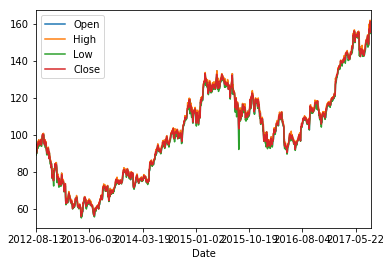

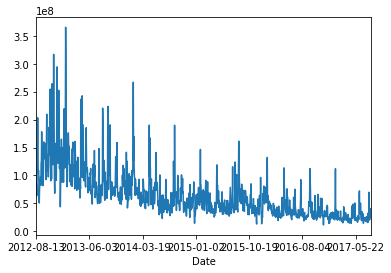

In [37]:
df[['Open', 'High', 'Low', 'Close']].plot()
plt.show()
df['Volume'].plot()
plt.show()

In [50]:
def plotting_stocks(symbols_list, amount_of_stocks=1):
    for symbol in symbols_list[:amount_of_stocks]:
        csv_file = '{}/{}_data.csv'.format(directory, symbol)
        df = pd.read_csv(csv_file)
        df = df.drop('Name', 1)
        df.set_index('Date', inplace=True)
        plt.rcParams['figure.figsize'] = [24, 12] # thanks to code yarns for this example https://codeyarns.com/2014/10/27/how-to-change-size-of-matplotlib-plot/
        df[['Open', 'High', 'Low', 'Close']].plot(title=symbol)
        plt.show()
        df['Volume'].plot(title=symbol)
        plt.show()

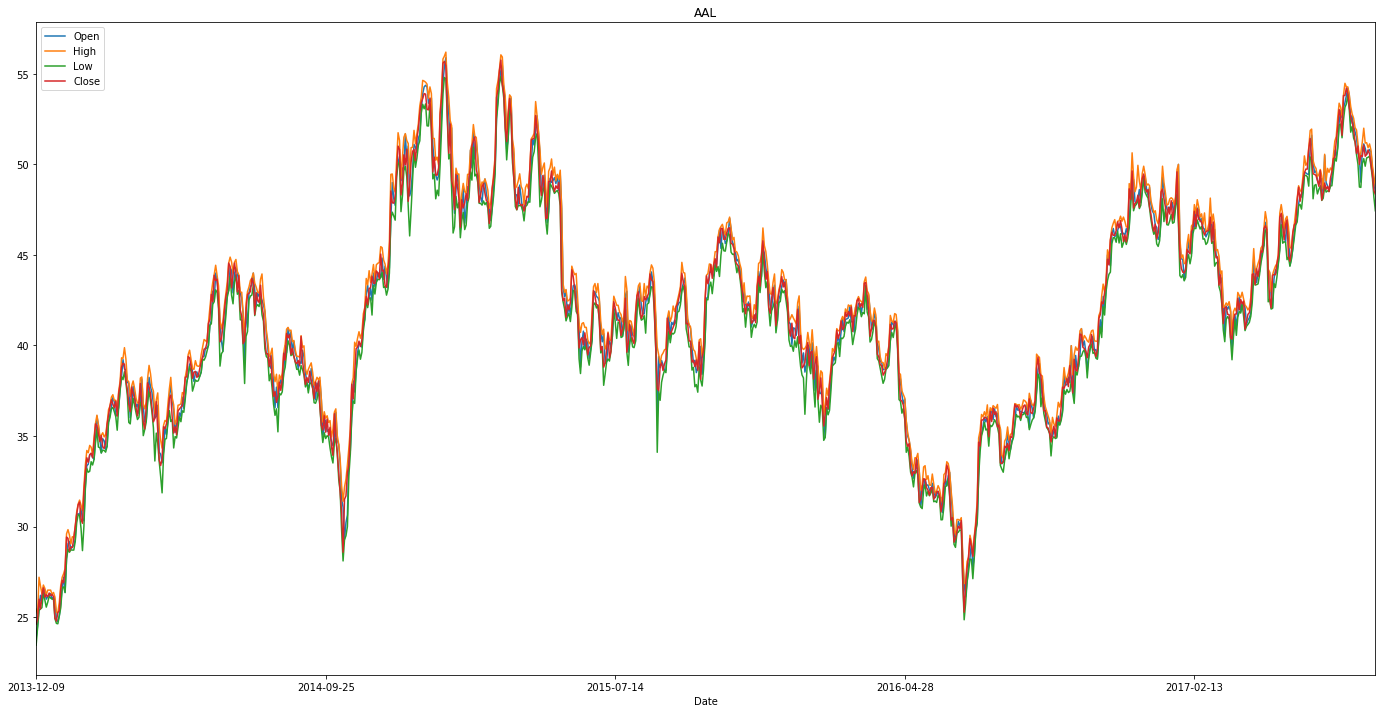

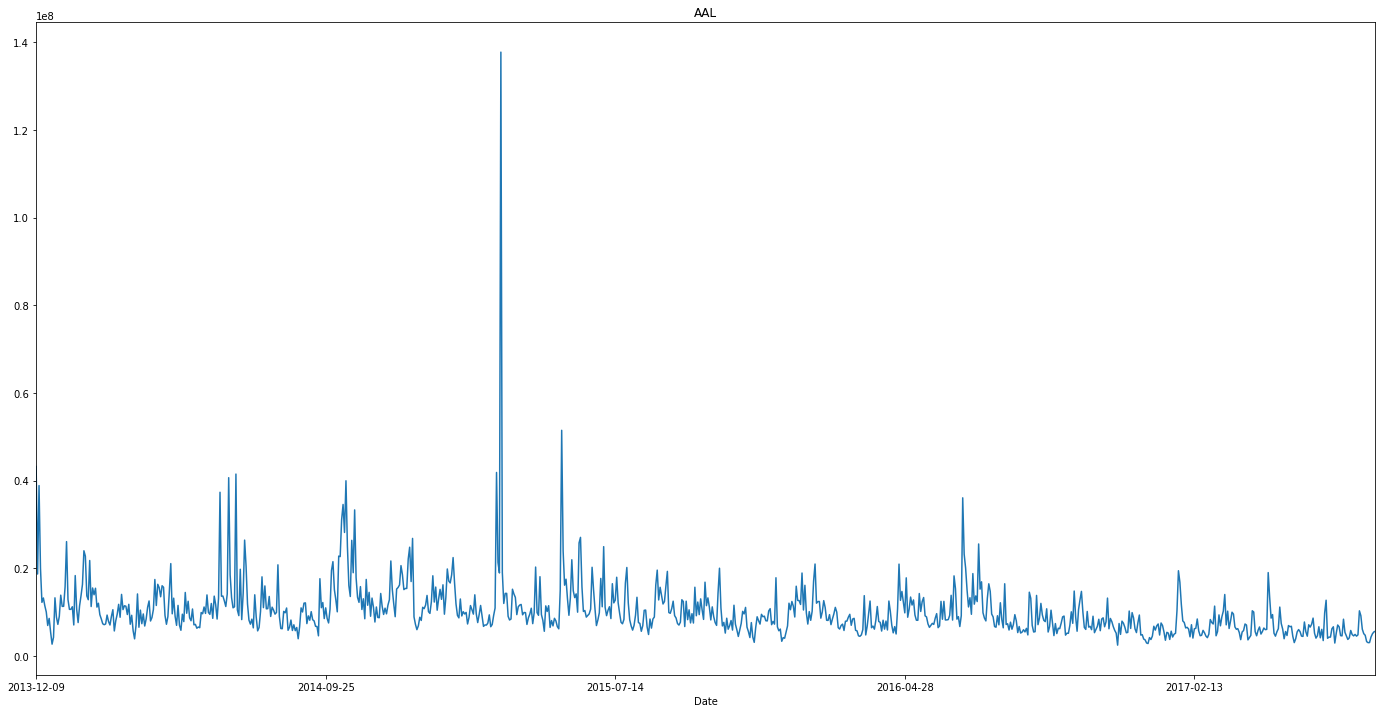

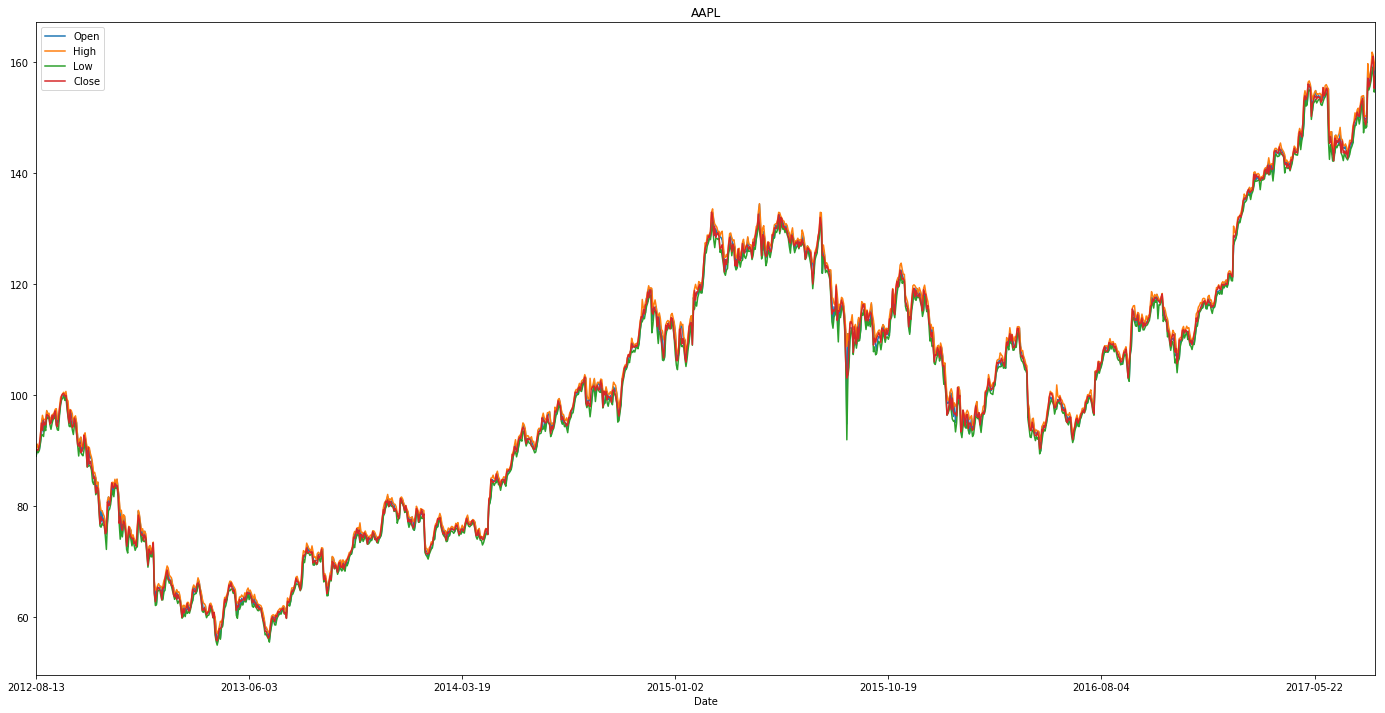

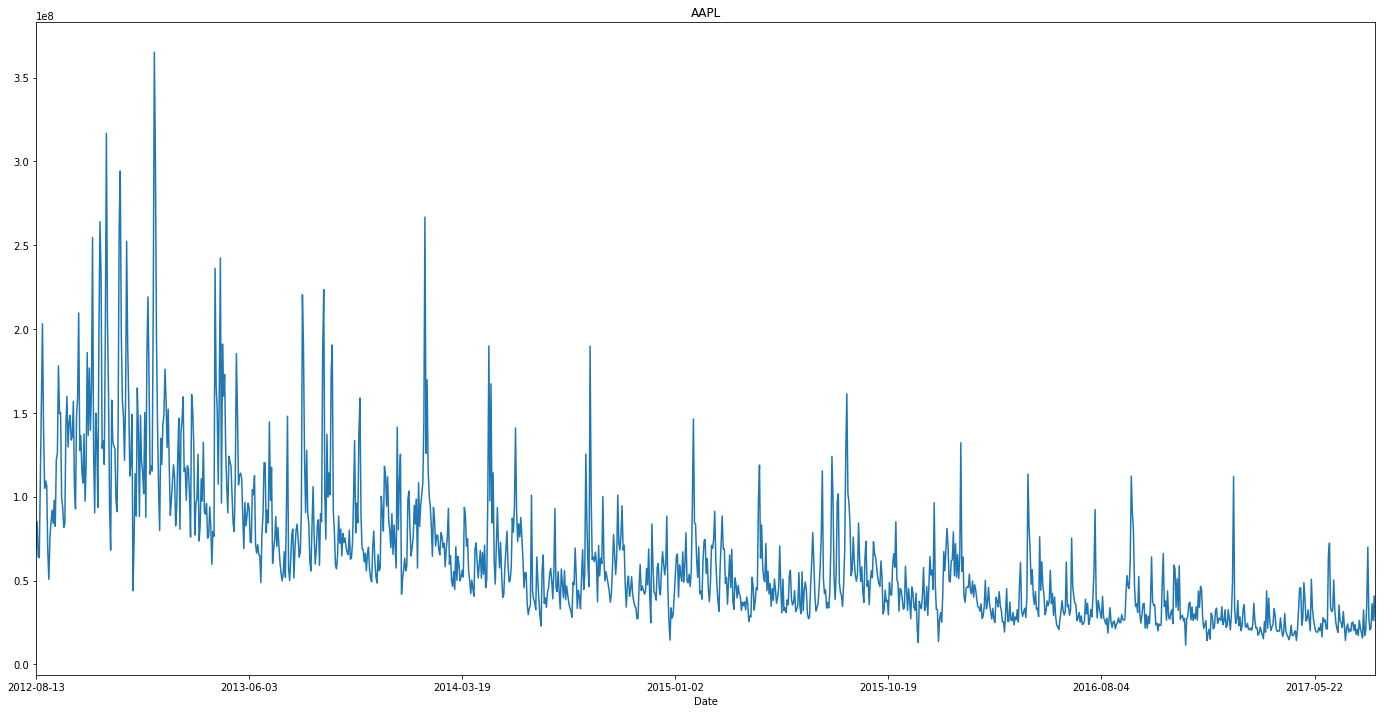

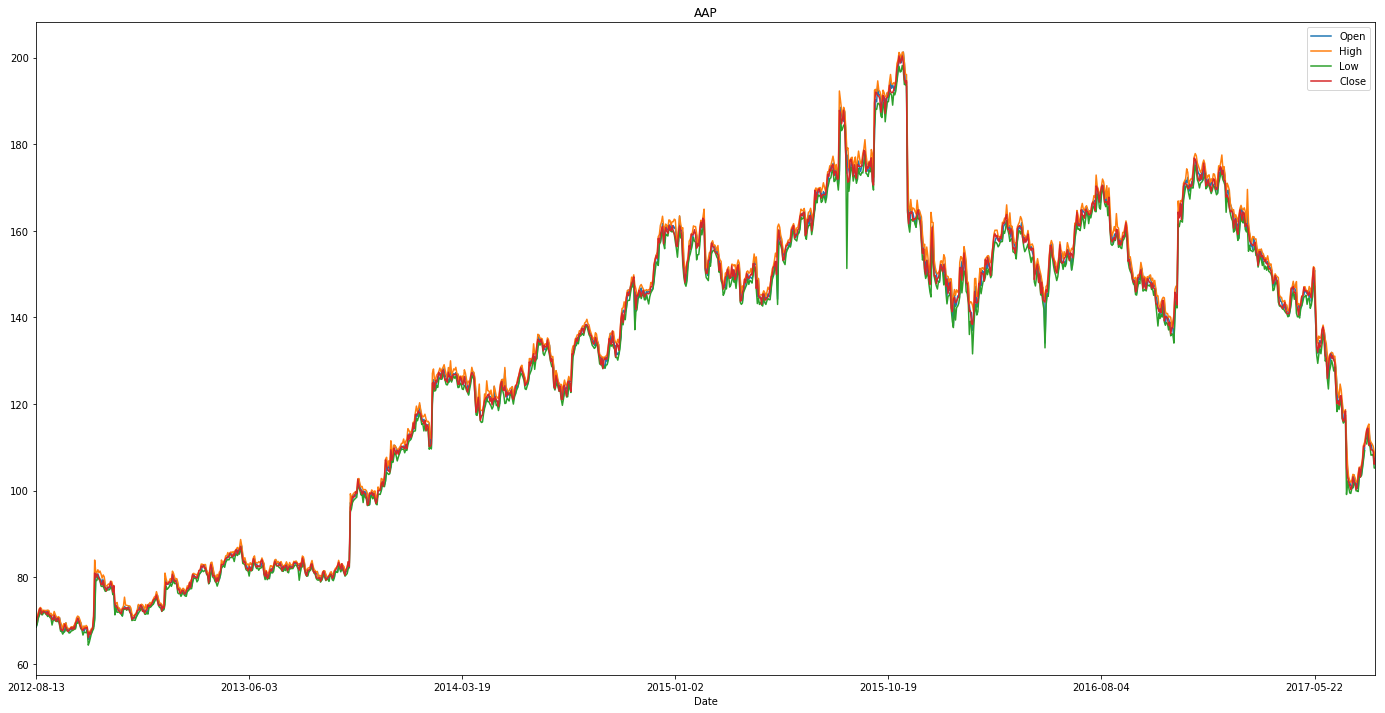

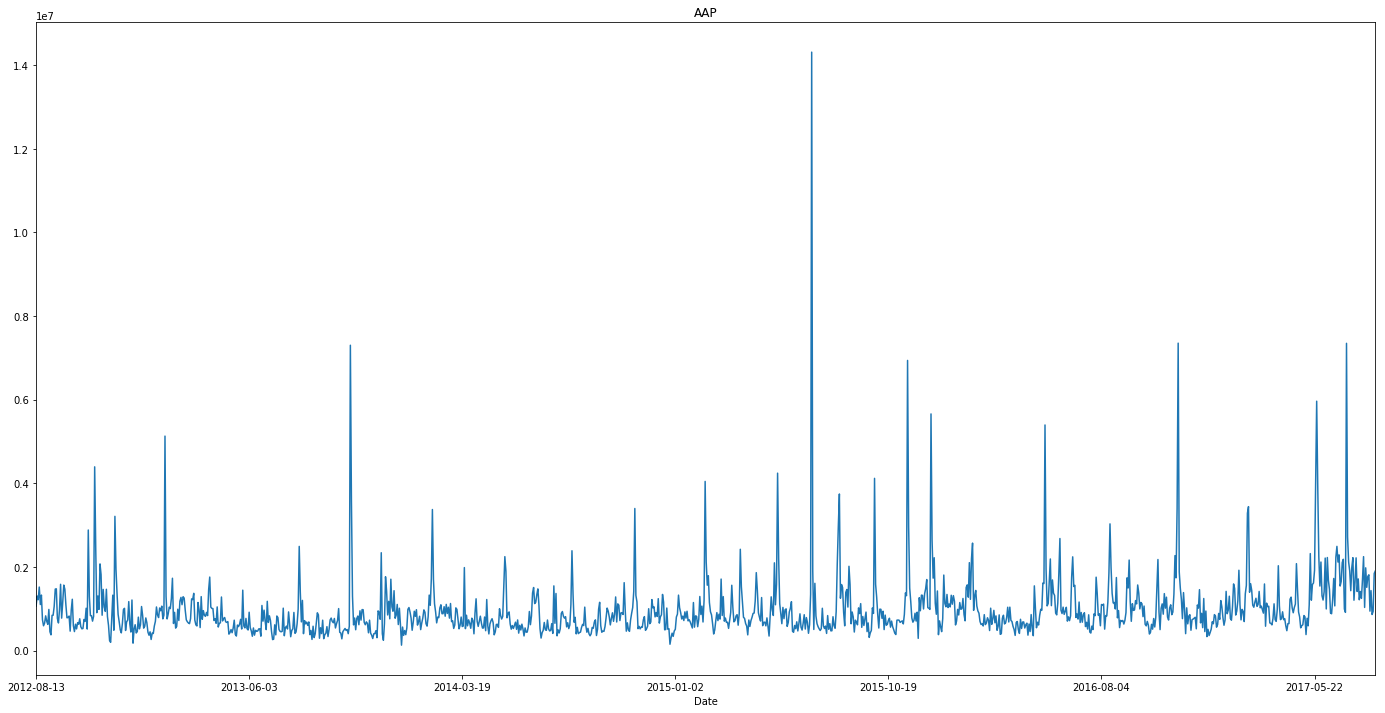

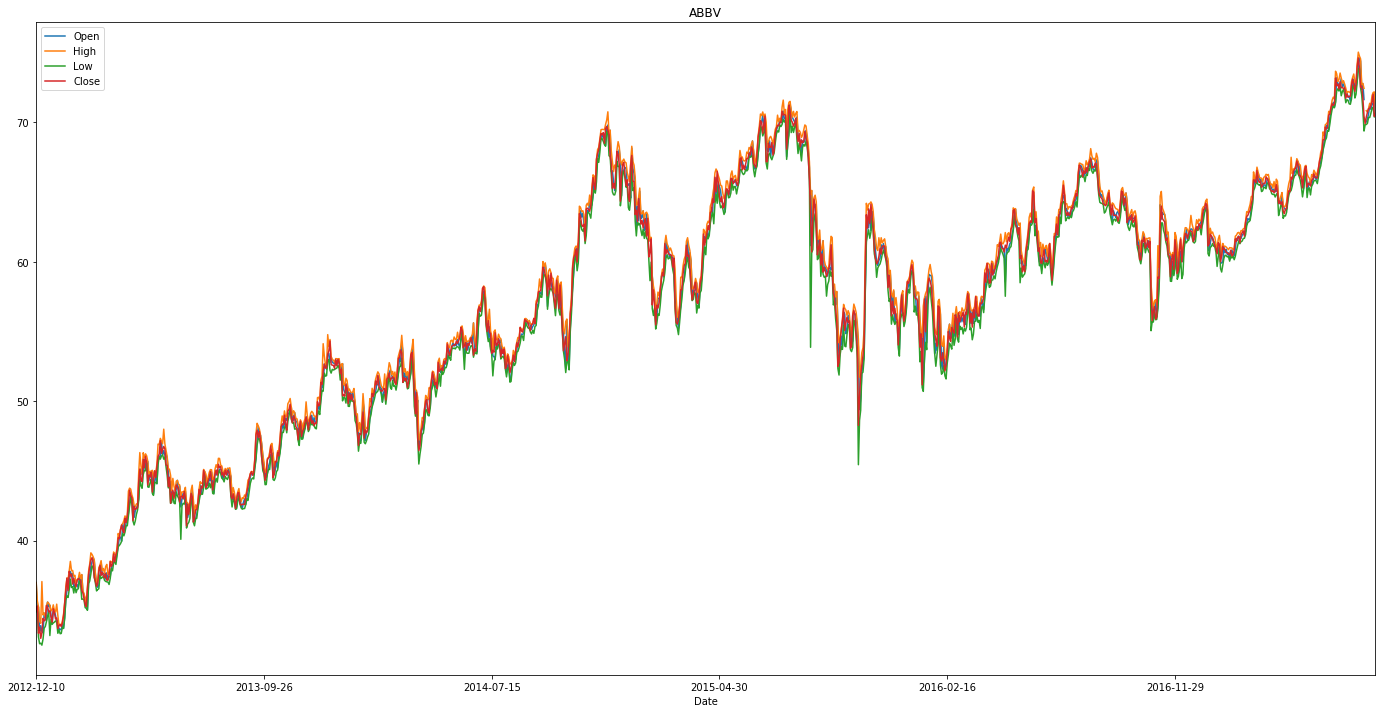

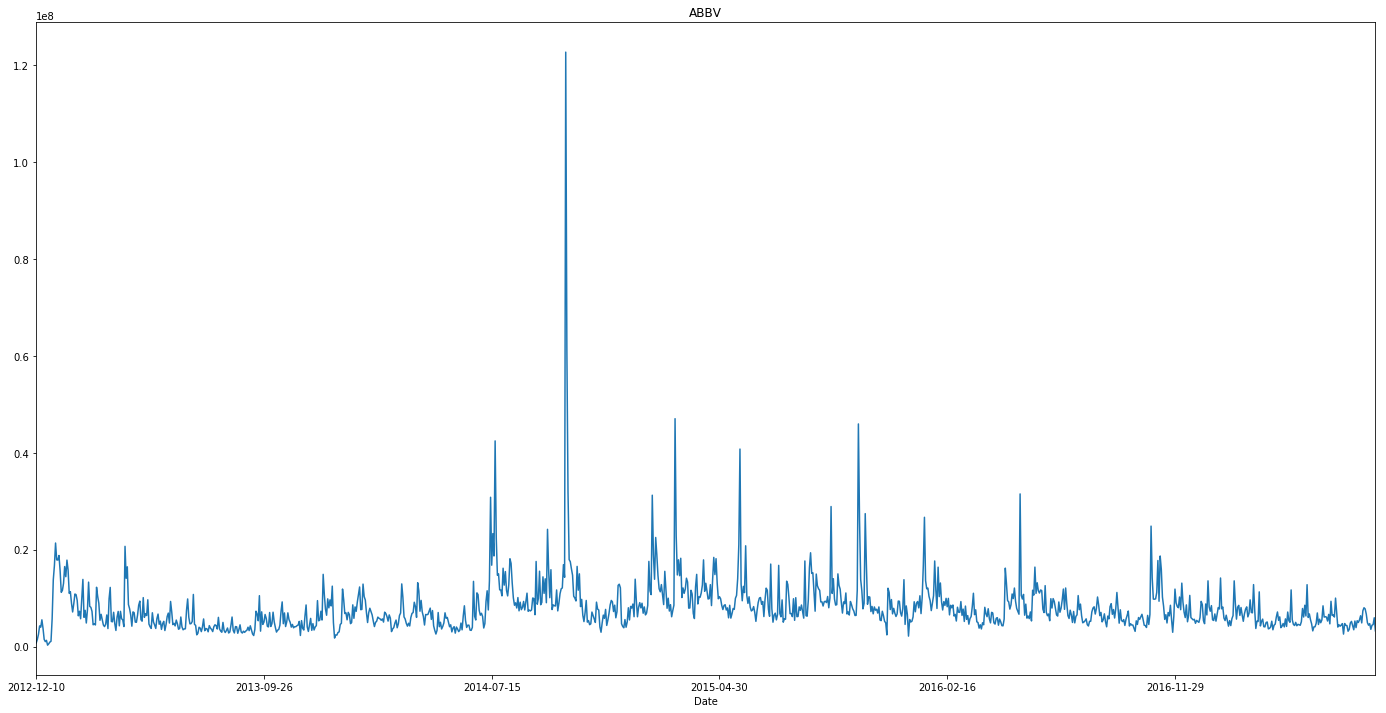

In [55]:
# printing out the first four stocks to get an idea of how each stock is individually represented.
plotting_stocks(symbols_list, 4)